# Laboratorium 2

### Przypomnienie implementacji algorytmu Strassena

In [45]:
using LinearAlgebra, DataFrames, BenchmarkTools, GFlops, Statistics, Plots

In [2]:
function divide_matrix(M, n)
    """
    :return: Four pieces of Matrix M (divided in half)
    This is an auxiliary function for strassen
    """
    m = div(n, 2)
    A11 = M[1:m, 1:m]
    A12 = M[1:m, m+1:n]
    A21 = M[m+1:n, 1:m]
    A22 = M[m+1:n, m+1:n]

    return A11, A12, A21, A22
end

divide_matrix (generic function with 1 method)

In [3]:
function strassen(A, B)
    """
    :return: C = A * B where A, B, C are matrices
    We can assume that dimensions of A and B are 2 ^ p.
    """
    
    n = size(A, 1)

    if n == 1
        
        if typeof(A) == Vector{Float64} && typeof(B) == Vector{Float64}
            return A .* B
        end
        
        return A * B
    end

    A11, A12, A21, A22 = divide_matrix(A, n)
    B11, B12, B21, B22 = divide_matrix(B, n)

    
    P1 = strassen(A11 + A22, B11 + B22)
    P2 = strassen(A21 + A22, B11)
    P3 = strassen(A11, B12 - B22)
    P4 = strassen(A22, B21 - B11)
    P5 = strassen(A11 + A12, B22)
    P6 = strassen(A21 - A11, B11 + B12)
    P7 = strassen(A12 - A22, B21 + B22)

    C11 = P1 + P4 - P5 + P7
    C12 = P3 + P5
    C21 = P2 + P4
    C22 = P1 - P2 + P3 + P6

    return vcat(hcat(C11, C12), hcat(C21, C22))
end

strassen (generic function with 1 method)

## Rekurencyjne odwracanie macierz


### Opis algorytmu
Algorytm przyjmuję na wejściu macierz. Jego zadaniem jest znaleźć macierz odwrotną do zadanej. Robi to metodą rekurencyjną, zgodnie z wzorami:

#### Macierz A
\begin{bmatrix}
A_{11} & A_{12} \\
A_{21} & A_{22}
\end{bmatrix}


#### Inwersja macierzy A
\begin{bmatrix}
A_{11}^{-1} \left( I + A_{12} S_{22}^{-1} A_{21} A_{11}^{-1} \right) & -A_{11}^{-1} A_{12} S_{22}^{-1} \\
-S_{22}^{-1} A_{21} A_{11}^{-1} & S_{22}^{-1}
\end{bmatrix} 

### Pseudokod
Gdy macierzy nie da się już podzielić (macierz 1x1) wówczas jej inwersja liczona jest przy pomocy wzoru: $A^{-1} = \frac{1}{A}$


### Implementacja

In [4]:
struct NonSquareMatrixError <: Exception
    message::String
end

function matrix_inverse(A)
    """
    :return matrix B, such that A * B = I
    """
    
    n = size(A, 1)
    m = size(A, 2)
    
    if n != m 
        throw(NonSquareMatrixError("Matrix is not the square"))
    end
        
    if n == 1
        return [1 / A[1, 1]]
    end
    
        
    m = div(n, 2)
    A11, A12, A21, A22 = divide_matrix(A, n)
    
    A11_inversed = matrix_inverse(A11)
    S22 = A22 - strassen(strassen(A21, A11_inversed), A12)
    S22_inversed = matrix_inverse(S22)
    
    
    
    B = zeros(n, n)
    eye = Matrix{Float64}(I, div(n, 2) , div(n, 2))
    
    B[1:m, 1:m] = strassen(A11_inversed, eye + strassen(strassen(strassen(A12, S22_inversed), A21), A11_inversed))
    B[1:m, m+1:n] = strassen(strassen(-A11_inversed, A12), S22_inversed)
    B[m+1:n, 1:m] = strassen(strassen(-S22_inversed, A21), A11_inversed)
    B[m+1:n, m+1:n] = S22_inversed
    
    return B
    
end

matrix_inverse (generic function with 1 method)

In [ ]:
# To check corectness
# This implementation may be unstable
eps = 10 ^ -5
min_value = 0.00000001
max_value = 1
for j in 1:3
    for i in 1:8
        A = min_value .+ (max_value - min_value) * rand(2 ^ i, 2 ^ i)
        
        C = matrix_inverse(A)
        
        B = matrix_inverse(C)

        if isapprox(A, B, atol=eps) == false
            println("FALSE!!!", size(A, 1))
            
        end
    end
end

### Pomiary

In [41]:
min_value = 0.00000001
max_value = 1
inversion_times = DataFrame(size = [], flops= [], time = [])

for i in 1: 5
    for size in 1: 8
        A = min_value .+ (max_value - min_value) * rand(2 ^ size, 2 ^ size)
        m_time = @elapsed matrix_inverse(A)
        m_flops = @count_ops matrix_inverse($A)
        push!(inversion_times, [size * size, m_flops, m_time])
    end
end     

In [42]:
for i in 1:nrow(inversion_times)
    inversion_times[i, :flops] = inversion_times[i, :flops].add64 + inversion_times[i, :flops].sub64 + inversion_times[i, :flops].div64 + inversion_times[i, :flops].neg64 + inversion_times[i, :flops].mul64
end
display(inversion_times)

,size,flops,time
,Any,Any,Any
1,1,6,0.000372
2,4,208,0.0141748
3,9,2460,0.0003199
4,16,21916,0.0024123
5,25,173556,0.014207
6,36,1298188,0.134042
7,49,9425940,0.886557
8,64,67346956,7.52373
9,1,6,1.95e-5


In [43]:
inversion_time_group = groupby(inversion_times, [:size])
inversion_time_statistics = combine(inversion_time_group, "time" => mean, "flops" => mean, "time" => std, "flops" => std)

,size,time_mean,flops_mean,time_std,flops_std
,Any,Float64,Float64,Float64,Float64
1,1,8.912e-5,6.0,0.000158139,0.0
2,4,0.0028682,208.0,0.00632058,0.0
3,9,0.00031738,2460.0,1.33074e-5,0.0
4,16,0.00336974,21916.0,0.00158807,0.0
5,25,0.0241682,173556.0,0.0137473,0.0
6,36,0.177778,1.29819e6,0.0698896,0.0
7,49,1.06193,9.42594e6,0.113642,0.0
8,64,7.59787,6.7347e7,0.249568,0.0


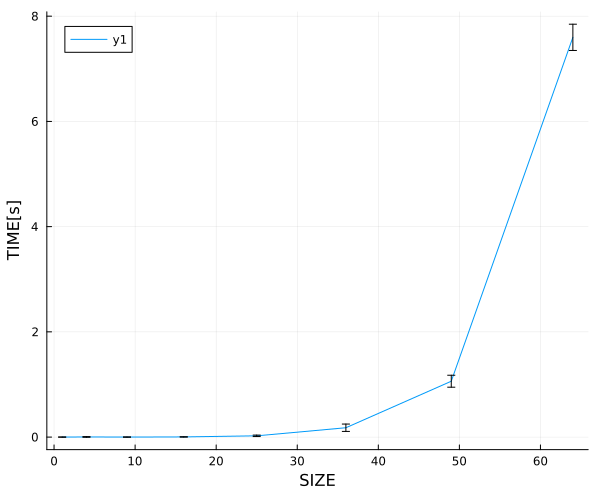

In [57]:
plot(inversion_time_statistics.size, inversion_time_statistics.time_mean, 
    size = (600, 500), yerr=inversion_time_statistics.time_std,
    yaxis = "TIME[s]", xaxis = "SIZE")

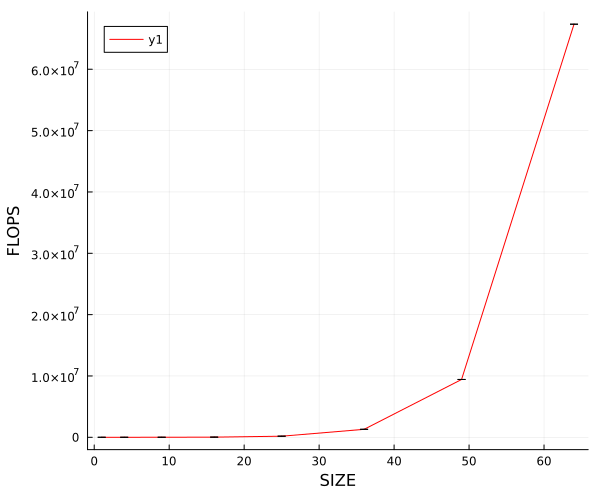

In [58]:
plot(inversion_time_statistics.size, inversion_time_statistics.flops_mean, 
    size = (600, 500), color="red",yerr=inversion_time_statistics.flops_std,
    yaxis = "FLOPS", xaxis = "SIZE")

### Złożoność obliczeniowa
Nasza implementacja odwracania macierzy, do mnożenia macierzy używa algorytmu Strassena, którego złożoność wynosi: O(n$^{\log_2(7)}$). Złożoność obliczeniowa algorytmu to rozwiązanie równania: <br>
<center>
$O(n) = 2 \cdot O\left(\frac{n}{2}\right) + 10 \cdot O(\frac{n}{2}^{\log_2(7)}) + d$
</center>
gdzie n to liczba elementów w jednym wierszu macierzy. <br>

Na podstawie [Master Theorem](https://en.wikipedia.org/wiki/Master_theorem_(analysis_of_algorithms)) złożoność obliczeniowa tego  algorytmu wynosi $O({n}^{\log_2(7)})$




### Porównanie z MATLABem

Kod w Matlab
```Matlab
A = [0.5488, 0.5929; 
    0.7094, 0.0734];

A_inv = inv(A);
fprintf("A");
disp(A_inv);

fprintf("A2");
A2 = [0.2722, 0.1980, 0.1500, 0.4826;
    0.6070, 0.3818, 0.2489, 0.6313;
    0.1088, 0.9294, 0.1723, 0.5508;
    0.3195, 0.5077, 0.3096, 0.9883];
disp(A2);
```

#### Wyniki
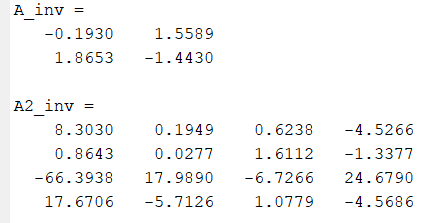

In [59]:
A = [0.5488 0.5929; 
    0.7094 0.0734];

A2 = [0.2722 0.1980 0.1500 0.4826;
    0.6070 0.3818 0.2489 0.6313;
    0.1088 0.9294 0.1723 0.5508;
    0.3195 0.5077 0.3096 0.9883];

display(matrix_inverse(A))
display(matrix_inverse(A2))


2×2 Matrix{Float64}:
 -0.192995   1.55894
  1.86526   -1.44299

4×4 Matrix{Float64}:
   8.30305    0.194897   0.623801  -4.52664
   0.864319   0.027741   1.61119   -1.33773
 -66.3938    17.989     -6.72664   24.679
  17.6706    -5.71258    1.07787   -4.56863

Otrzymane macierze zgadzają się z tymi obliczonymi przy użyciu funkcji inv() w Matlabie